# Backtesting Report

> This notebook will go through   some details of the backtesting results. 

 

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns
 
    
plt.style.use('ggplot')
%matplotlib inline

## Load Historical Price Data.


<div style="background: #fff8dc; border:1px solid #ede7cd; padding: 10px">

Load histrical price data for every instrument that has ever included in the TSX60 index. 
$$\scriptsize{
   \begin{array}{lll}
   &\\
   \mbox{ Handle missing data.}\\
   &\\
   \end{array}
   }
   $$
</div>

In [2]:
px=pd.read_excel('./data/pca/pca_tsx60.xlsx')\
    .fillna(method='ffill', inplace=False)\
    .fillna(method='bfill', inplace=False)
px['Datetime']=px['Datetime'].apply(lambda x: x.strftime('%Y%m%d'))
px.set_index('Datetime', inplace=True)

## Load Benchmark  Data.

<div style="background: #fff8dc; border:1px solid #ede7cd; padding: 10px">

Covering period from 2009-05-15 to 2019-06-28.

</div>
 
 

In [3]:
bmk=pd.read_excel('./data/pca/pca_etf.xlsx')
bmk=bmk[bmk['Date']<=20190628]

## Load  smart beta strategy results.

<div style="background: #fff8dc; border:1px solid #ede7cd; padding: 10px">


Since the benchmark covers period from 2009-05-15 to 2019-06-28, we would test our strategy over the same time period 



</div>
 
  
 
 

In [4]:
stgy=pd.read_excel('./data/pca/pca_stgy.xlsx')
stgy=stgy[stgy['Datetime']<=20190628]

## Calculate  cumulative returns for both strategies

<div style="background: #fff8dc; border:1px solid #ede7cd; padding: 10px">


Kalman-HMM based, daily rebalanced, smart beta strategy.



</div>
 
  

In [5]:
_stgy=dict()
_bmk=dict()

dl=stgy.Datetime.unique()
day=dl[0]
_stgy[day]=0
_bmk[day]=0
for name in dl[1:]:
    group=stgy[stgy['Datetime']==day].copy()
    px0=px.loc[str(day)][group.Company.tolist()].values
    px1=px.loc[str(name)][group.Company.tolist()].values
    rtn=px1/px0-1
    _stgy[name]=0.01*np.dot(group['% Wgt'].values, rtn)
    day=name

dl= bmk.Date.unique()
day=dl[0]
for name in dl[1:]:
    group=bmk[bmk['Date']==day].copy()
    px0=px.loc[str(day)][group.Company.tolist()].values
    px1=px.loc[str(name)][group.Company.tolist()].values
    rtn=px1/px0-1
    _bmk[name]=0.01*np.dot(group['% Wgt'].values, rtn)
    day=name
    
#performance   
perf_stgy=pd.DataFrame.from_dict(_stgy, orient='index')
perf_stgy.columns=['return_stgy']
perf_stgy['SMART BETA']=(1+perf_stgy['return_stgy']).cumprod() 
perf_bmk=pd.DataFrame.from_dict(_bmk, orient='index')
perf_bmk.columns=['return_bmk'] 
perf_bmk['ISHARES S&P/TSX 60 INDEX ETF']=(1+perf_bmk['return_bmk']).cumprod() 
perf_stgy['return_bmk']=perf_bmk['return_bmk']
perf_stgy['ISHARES S&P/TSX 60 INDEX ETF']=perf_bmk['ISHARES S&P/TSX 60 INDEX ETF']

ix=pd.read_csv('./data/yahoo/TSX60.csv')[['Date','Price']]
ix['Date']=pd.to_datetime(ix['Date']).apply(lambda x: int(x.strftime("%Y%m%d")))
ix.set_index('Date', inplace=True)
ix.sort_index(inplace=True)
dt=pd.DataFrame(index=perf_stgy.index)
dt.index.name='Date'
ix1=pd.merge(dt, ix, on='Date', how='left')
ix1.fillna(method='ffill', inplace=True)
ix1['return']=(ix1/ix1.shift(1)-1).fillna(0)
ix1['INDEX']=(1+ix1['return']).cumprod()
  
perf_stgy['S&P/TSX 60 INDEX']=ix1['INDEX'].values
perf_stgy.index=[str(x)[:4]+'-'+str(x)[4:6]+'-'+str(x)[6:] for x in perf_stgy.index]

## Findings


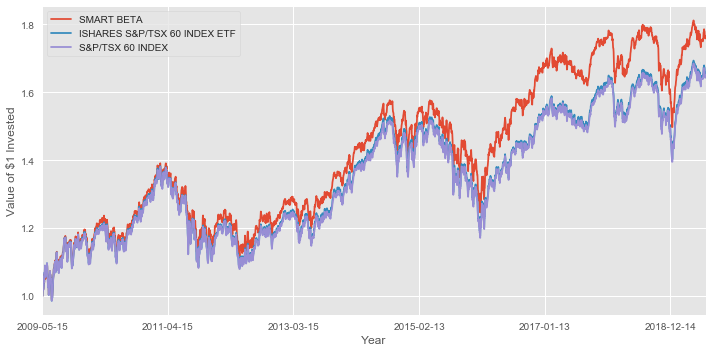

In [6]:
plt.figure(figsize=(10,5))
ax=perf_stgy[['SMART BETA','ISHARES S&P/TSX 60 INDEX ETF','S&P/TSX 60 INDEX',]].plot(figsize=(10,5));
ax.set(xlabel="Year", ylabel="Value of $1 Invested") 
ax.legend(frameon=True)
plt.tight_layout()
plt.savefig('./output/fig/stgy')

In [7]:
perf_stgy.index=pd.to_datetime(perf_stgy.index)
perf_stgy.index.name='Date'

Shape_stgy=dict()
Shape_bmk=dict()
for name, group in perf_stgy.groupby(perf_stgy.index.year):
    group=group.fillna(method='bfill', inplace=False)
    p_stgy=group['SMART BETA'].values.tolist()
    b_stgy=group['ISHARES S&P/TSX 60 INDEX ETF'].values.tolist()
    Shape_stgy[name]=[252*(p_stgy[-1]/p_stgy[0]-1)*100/len(group),
                      np.sqrt(252)*group['return_stgy'].mean()/group['return_stgy'].std()]
    Shape_bmk[name]=[252*(b_stgy[-1]/b_stgy[0]-1)*100/len(group),
                     np.sqrt(252)*group['return_bmk'].mean()/group['return_bmk'].std()]
         

### Tracking Error / Information Ratio

---

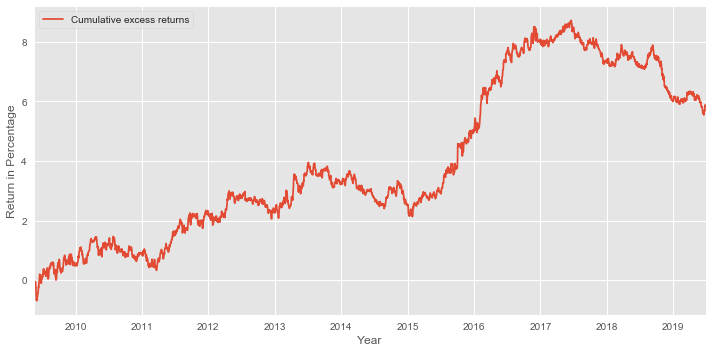

In [8]:
perf_stgy['error']=(perf_stgy['return_stgy']-perf_stgy['return_bmk'])*100
plt.figure(figsize=(10,5))
ax=perf_stgy['error'].cumsum().plot(figsize=(10,5), label='Cumulative excess returns')
ax.set(xlabel="Year", ylabel="Return in Percentage") 
plt.tight_layout()
ax.legend(frameon=True)
plt.savefig('./output/fig/excess')

---